### Moving average: This type of average is designed to respond quickly to price changes.

In [1]:
# Importing libraries and loading data into the dataframe.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', context='talk', palette='Dark2') # Setting the style of the plots.
my_year_month_fmt = mdates.DateFormatter('%m/%y') # Creating a custom data formatter.
import warnings

warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("merged_data.csv")

In [3]:
data.head(5)

Date    Open    High     Low   Close  Volume    SP500  ADS_Index  \
0  2016-01-06  753.57  765.73  748.00  760.40   16789  1990.26  -0.308089   
1  2016-01-07  740.00  755.31  735.28  741.45   22332  1943.09  -0.294335   
2  2016-01-08  752.49  756.25  728.92  730.91   16494  1922.03  -0.281488   
3  2016-01-11  732.50  736.00  719.56  734.56   18012  1923.67  -0.248493   
4  2016-01-12  733.99  748.34  733.99  744.51   15821  1938.68  -0.239263   

    Returns  Mkt-RF   SMB   HML   RF  Average_OC  Average_all  
0  0.002748   -1.35 -0.12  0.00  0.0     756.985     756.9250  
1 -0.002893   -2.44 -0.29  0.08  0.0     740.725     743.0100  
2 -0.024436   -1.11 -0.47 -0.03  0.0     741.700     742.1425  
3 -0.013710   -0.06 -0.65  0.34  0.0     733.530     730.6550  
4  0.002951    0.71 -0.40 -0.77  0.0     739.250     740.2075

In [4]:
df=data[['Date', 'SP500', 'Average_OC']]

In [5]:
df.head(5)

Date    SP500  Average_OC
0  2016-01-06  1990.26     756.985
1  2016-01-07  1943.09     740.725
2  2016-01-08  1922.03     741.700
3  2016-01-11  1923.67     733.530
4  2016-01-12  1938.68     739.250

In [6]:
# Indexing the date to plot a good time-series on the graph
import datetime
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
del df['Date']

### Exponential moving average for 5, 10 and 20 days for GOOGLE STOCK 

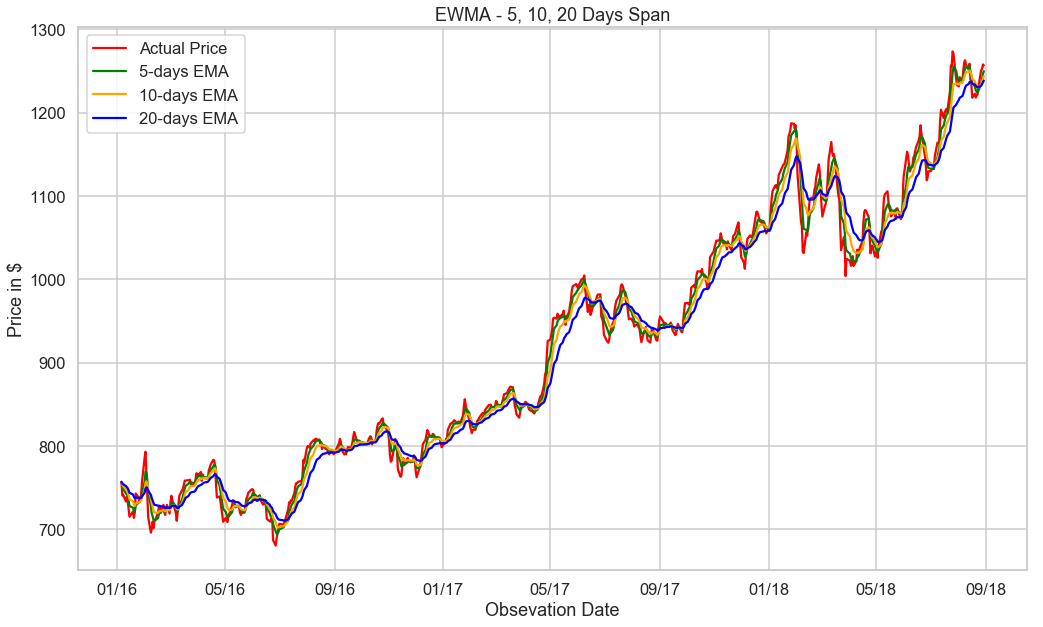

In [7]:
# Calculating a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
start_date = '2016-01-06'
end_date = '2018-08-30'


ema_five = df.ewm(span=5, adjust=False).mean()
ema_ten = df.ewm(span=10, adjust=False).mean()
ema_twenty = df.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(17,10))

ax.plot(df.loc[start_date:end_date, :].index, df.loc[start_date:end_date, 'Average_OC'], label='Actual Price', color = 'red')
ax.plot(ema_five.loc[start_date:end_date, :].index, ema_five.loc[start_date:end_date, 'Average_OC'], label = '5-days EMA', color = 'green')
ax.plot(ema_ten.loc[start_date:end_date, :].index, ema_ten.loc[start_date:end_date, 'Average_OC'], label = '10-days EMA', color = 'orange')
ax.plot(ema_twenty.loc[start_date:end_date, :].index, ema_twenty.loc[start_date:end_date, 'Average_OC'], label = '20-days EMA', color = 'blue')

ax.legend(loc='best')
ax.set_title('EWMA - 5, 10, 20 Days Span')
ax.set_xlabel('Obsevation Date')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

### MOVING AVERAGE TRADING STRATEGY:
BUY when 5 day EMA & 10 day EMA crosses from below to above the 20 days EMA (that is the GREEN & yellow line crosses BLUE line from down to top) and HOLD or create a alert strategy to prepare for BUY when 5 days EMAs crosses 20 days EMA. Also, the rule can be applies vice-versa for SELL when the 5 day & 10 day EMA crosses from above to BELOW the 20 days EMA

In [8]:
#implementation
trad_strat = ema_five.apply(np.sign)

for index, row in trad_strat.iterrows():
    if ema_five.loc[index,'Average_OC'] > ema_twenty.loc[index,'Average_OC'] and ema_ten.loc[index,'Average_OC'] > ema_twenty.loc[index,'Average_OC']:
        trad_strat.loc[index,'Average_OC'] = 1   
    elif ema_five.loc[index,'Average_OC'] < ema_twenty.loc[index,'Average_OC'] and ema_ten.loc[index,'Average_OC'] < ema_twenty.loc[index,'Average_OC']:
        trad_strat.loc[index,'Average_OC'] = -1   
    else:
        trad_strat.loc[index,'Average_OC'] = 0


In [9]:
# initial price 756.90
# last price 1256.80
initial_amt = 100000
total_shares = 30
print('Account balance ',initial_amt)
print('Initial number of shares owned ',total_shares)
avg_price = 756.90
initial_val = 122707  #initial amount+total_shares+avg_price

for index, row in trad_strat.iterrows():
    if trad_strat.loc[index,'Average_OC'] == 1:
        if (initial_amt - df.loc[index,'Average_OC'])> 0 :
            initial_amt -= df.loc[index,'Average_OC']
            avg_price = ((avg_price*total_shares)+df.loc[index,'Average_OC'])/(total_shares+1)
            total_shares = total_shares + 1;
            df.loc[index,'Signal'] = "Buy"
        else:
            df.loc[index,'Signal'] = "Buy Alert"         
    elif trad_strat.loc[index,'Average_OC'] == -1:
        if total_shares - 1 > 0 :
            df.loc[index,'Signal'] = "Sell"
            avg_price = ((avg_price*total_shares)-df.loc[index,'Average_OC'])/(total_shares-1)
            initial_amt += df.loc[index,'Average_OC'];
            total_shares = total_shares - 1;
        else:
            df.loc[index,'Signal'] = "Sell Alert"
    else:
        df.loc[index,'Signal'] = "Hold"

print('----------------Signals Given During Day To Day Trade------------------------')

total_val = initial_amt + total_shares * 1256.80  
print(df.head(20))

print('----------------Results-------------------------')
print('Balance left in Account',initial_amt)
print('Total Number of shares ',total_shares)
print('Total value of the shares ',total_val)
print('Percetage Profit ',((total_val-initial_val)/initial_val)*100)

Account balance  100000
Initial number of shares owned  30
----------------Signals Given During Day To Day Trade------------------------
              SP500  Average_OC Signal
Date                                  
2016-01-06  1990.26     756.985   Hold
2016-01-07  1943.09     740.725   Sell
2016-01-08  1922.03     741.700   Sell
2016-01-11  1923.67     733.530   Sell
2016-01-12  1938.68     739.250   Sell
2016-01-13  1890.28     734.500   Sell
2016-01-14  1921.84     725.015   Sell
2016-01-15  1880.33     715.245   Sell
2016-01-19  1881.33     721.540   Sell
2016-01-20  1859.33     713.890   Sell
2016-01-21  1868.99     720.505   Sell
2016-01-22  1906.90     743.235   Sell
2016-01-25  1877.08     738.875   Sell
2016-01-26  1903.63     733.345   Sell
2016-01-27  1882.95     736.000   Sell
2016-01-28  1893.36     741.655   Sell
2016-01-29  1940.24     756.515   Hold
2016-02-01  1939.38     786.165    Buy
2016-02-02  1903.03     793.225    Buy
2016-02-03  1912.53     766.500    Buy
-----

### Portfolio Return Trading Strategy

In [10]:
# Taking the difference between the prices and the EMA timeseries
df1 = df[['Average_OC','SP500']].copy()
trading_positions_raw = df1 - ema_five
trading_positions_raw.tail(10)

Average_OC      SP500
Date                             
2018-08-17  -17.868024  10.455191
2018-08-20   -8.692016  11.583461
2018-08-21   -8.848011  11.662307
2018-08-22   -4.225341   7.014871
2018-08-23   -2.113560   1.449914
2018-08-24    4.887626  12.773276
2018-08-27   16.381751  23.215517
2018-08-28   11.901167  15.997012
2018-08-29   11.624112  21.678008
2018-08-30    7.032741   5.845339

In [11]:
# Taking the sign of the difference to determine whether the price or the EMA is greater
trading_positions = trading_positions_raw.apply(np.sign) *(1/2)
trading_positions.tail(10)

Average_OC  SP500
Date                         
2018-08-17        -0.5    0.5
2018-08-20        -0.5    0.5
2018-08-21        -0.5    0.5
2018-08-22        -0.5    0.5
2018-08-23        -0.5    0.5
2018-08-24         0.5    0.5
2018-08-27         0.5    0.5
2018-08-28         0.5    0.5
2018-08-29         0.5    0.5
2018-08-30         0.5    0.5

In [12]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)
trading_positions_final.tail()

Average_OC  SP500
Date                         
2018-08-24        -0.5    0.5
2018-08-27         0.5    0.5
2018-08-28         0.5    0.5
2018-08-29         0.5    0.5
2018-08-30         0.5    0.5

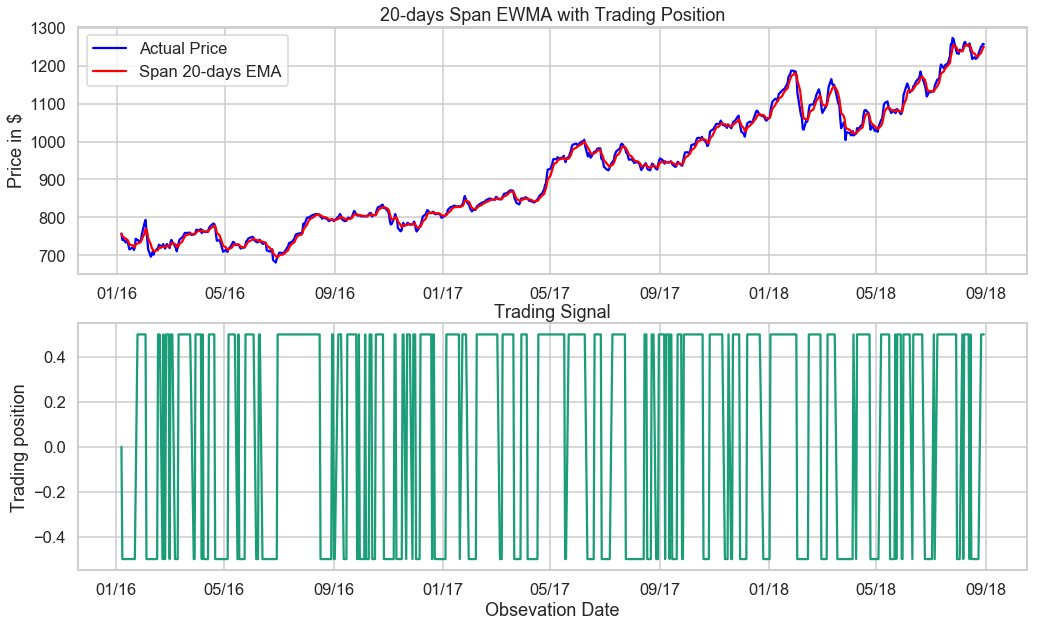

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17,10))

ax1.plot(df.loc[start_date:end_date, :].index, df.loc[start_date:end_date, 'Average_OC'], label='Actual Price', color = 'blue')
ax1.plot(ema_five.loc[start_date:end_date, :].index, ema_five.loc[start_date:end_date, 'Average_OC'], label = 'Span 20-days EMA', color = 'red')

ax1.set_title('20-days Span EWMA with Trading Position')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'Average_OC'], 
        label='Trading position')
ax2.set_title('Trading Signal')
ax2.set_xlabel('Obsevation Date')
ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

                                 Positive value means Buy and Negative value means sell.

In [14]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(df1).diff()
asset_log_returns.head()

Average_OC     SP500
Date                            
2016-01-06         NaN       NaN
2016-01-07   -0.021714 -0.023986
2016-01-08    0.001315 -0.010898
2016-01-11   -0.011076  0.000853
2016-01-12    0.007768  0.007773

To get all the strategy log-returns for all days, multiplying the strategy positions with the asset log-returns.

In [15]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

Average_OC     SP500
Date                            
2018-08-24   -0.003850  0.003090
2018-08-27    0.007931  0.003821
2018-08-28    0.000587  0.000135
2018-08-29    0.002205  0.002843
2018-08-30   -0.000427 -0.002220

### plot the cumulative log-returns and the cumulative total relative returns of our strategy for each of the assets

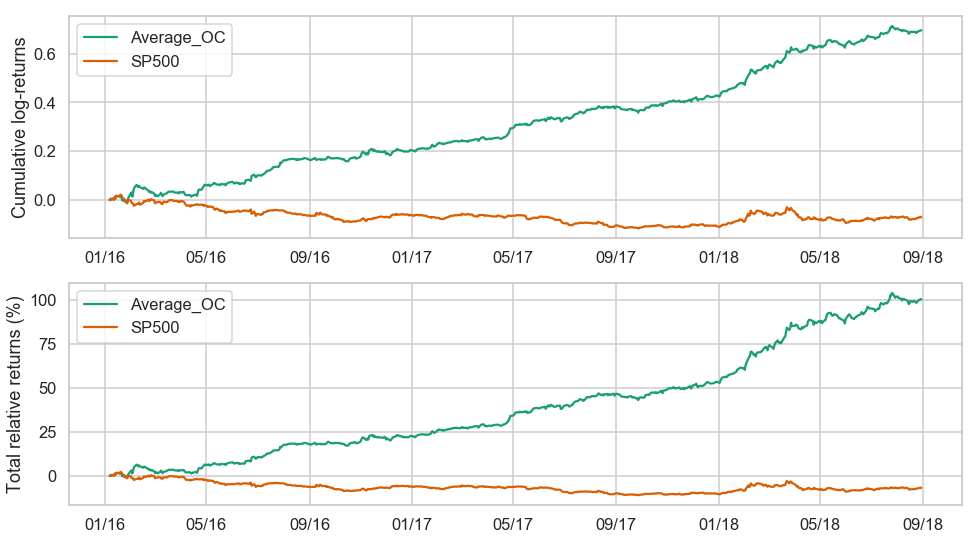

In [16]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))
ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

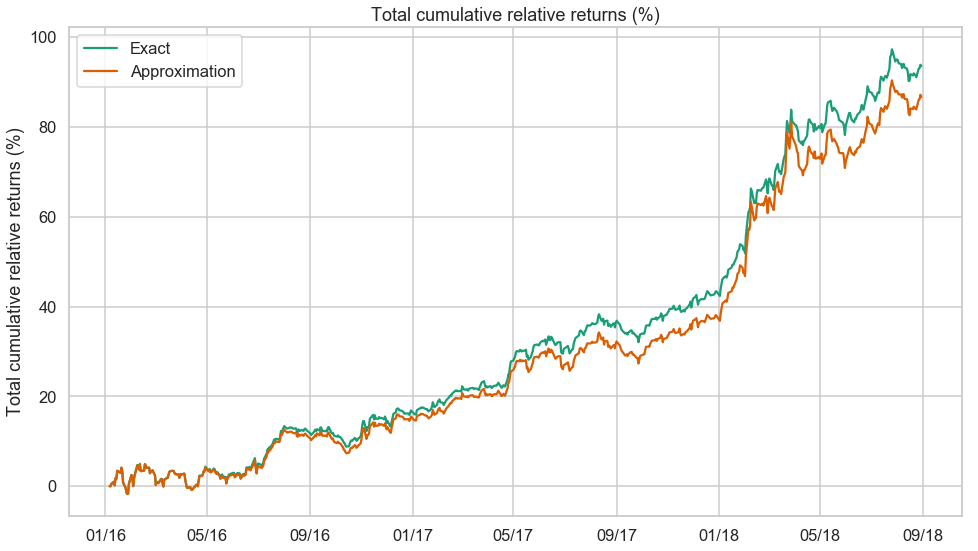

In [17]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_title('Total cumulative relative returns (%)')
ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [18]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is: 93.55%
Average yearly return is: 29.26%
